In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

In [2]:
file = 'sched_window_analysis.csv'
file_df = pd.read_csv(file)

file_df["Earliest Start datetime"] = ""
file_df["Due Date datetime"] = ""
file_df["Scheduling Window"] = ""


In [3]:
# convert Earliest Start and Due Date to datetime values
file_df["Earliest Start datetime"] = pd.to_datetime(file_df["SA: Earliest Start Permitted"],format="%m/%d/%Y %I:%M %p")
file_df["Due Date datetime"] = pd.to_datetime(file_df["SA: Due Date"],format="%m/%d/%Y %I:%M %p")
file_df["Scheduling Window"] = (file_df["Due Date datetime"]-file_df["Earliest Start datetime"])
file_df["Scheduling Window"] = file_df["Scheduling Window"].apply(lambda val: (val.total_seconds()/3600))

# get the Onsite SAs
onsite_df = file_df[file_df["SA: Type"]=="Onsite Visit"]

# get total number of onsite SAs
total_onsite = len(onsite_df["SA: Type"])

# get the SAs that went to the Scheduling Engine
onsite_df = onsite_df.loc[(onsite_df["SA: Schedule Exception Reason"] != "No Service Territory")& \
(onsite_df["SA: Schedule Exception Reason"] != "Invalid \"No Skill\" Skill Requirement on the Work Order.")& \
(onsite_df["SA: Schedule Exception Reason"] != "Parts are not available by the Due Date.") & \
(onsite_df["SA: Schedule Exception Reason"] != "Due Date is in the past.")]
num_onsite_sent_to_engine = len(onsite_df["SA: Type"])

# get the SAs that went straight to Sched Exception
sched_excep_df = file_df.loc[((file_df["SA: Schedule Exception Reason"] == "No Service Territory")| \
(file_df["SA: Schedule Exception Reason"] == "Invalid \"No Skill\" Skill Requirement on the Work Order.")| \
(file_df["SA: Schedule Exception Reason"] == "Parts are not available by the Due Date.") | \
(file_df["SA: Schedule Exception Reason"] == "Due Date is in the past.")) & (file_df["SA: Type"]=="Onsite Visit")]

# count the number of SAs that went straight to Sched Exception
num_sched_excep = len(sched_excep_df["SA: Type"])


# Scheduling Overview

<IPython.core.display.Javascript object>


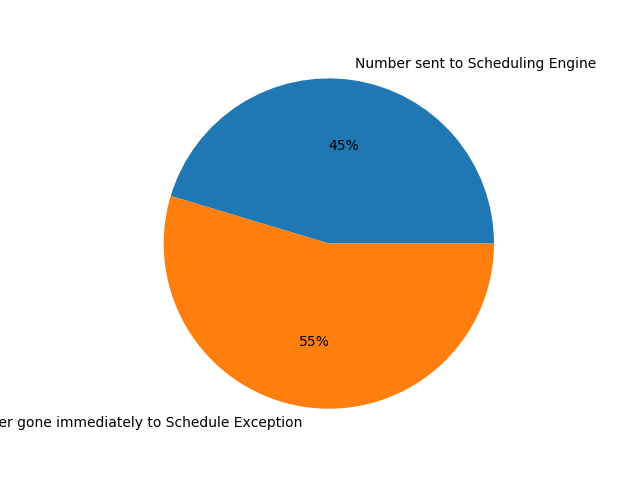

,Total Onsite SAs (Jan-June '19'),Number gone immediately to Schedule Exception,Number sent to Scheduling Engine,Number initially scheduled,Number truly auto-scheduled,Number where no Service Resource found,Percent immediately to Schedule Exception,Percent sent to Scheduling Engine,Percent initially scheduled,Percent no Service Resource found
0,2040,1115,925,338,32,587,54.66%,45.34%,36.54%,63.46%


In [40]:
sa_summary_table = pd.DataFrame({"Total Onsite SAs (Jan-June '19')": total_onsite,"Number sent to Scheduling Engine": num_onsite_sent_to_engine,"Number gone immediately to Schedule Exception": num_sched_excep,"Number initially scheduled": num_scheduled,"Number truly auto-scheduled":num_auto_sched,"Number where no Service Resource found": num_no_ssrs_found,"Percent sent to Scheduling Engine": "{:.2%}".format(num_onsite_sent_to_engine/total_onsite),"Percent immediately to Schedule Exception": "{:.2%}".format(num_sched_excep/total_onsite),"Percent initially scheduled": "{:.2%}".format((num_scheduled/num_onsite_sent_to_engine)),"Percent no Service Resource found": "{:.2%}".format((num_no_ssrs_found/num_onsite_sent_to_engine))},index=[0])
sa_summary_table = sa_summary_table[["Total Onsite SAs (Jan-June '19')","Number gone immediately to Schedule Exception","Number sent to Scheduling Engine","Number initially scheduled","Number truly auto-scheduled","Number where no Service Resource found","Percent immediately to Schedule Exception","Percent sent to Scheduling Engine","Percent initially scheduled","Percent no Service Resource found"]]
labels = ["Number sent to Scheduling Engine","Number gone immediately to Schedule Exception"]
sizes = [num_onsite_sent_to_engine,num_sched_excep]
plt.pie(sizes,labels=labels,autopct='%1.0f%%')
plt.axis('equal')
sa_summary_table

In [41]:





# group the SAs that went to the Scheduling Engine by the size of the Scheduling Window
window_bins = [0,2,4,6,8,10,12,100]
group_names = ["<2 hrs", "2-4 hrs", "4-6 hrs", "6-8 hrs", "8-10 hrs", "10-12 hrs", "12+ hrs"]
onsite_df["Scheduling Window Size"] = pd.cut(file_df["Scheduling Window"], window_bins, labels = group_names)


# All Valid SAs Scheduling Window Size

In [49]:
onsite_grouped_df = onsite_df.groupby(["Scheduling Window Size"])
onsite_grouped_df["Scheduling Window Size"].count()
# onsite_grouped_df["Scheduling Window"].median()

Scheduling Window Size
<2 hrs        90
2-4 hrs      158
4-6 hrs       65
6-8 hrs       60
8-10 hrs      53
10-12 hrs     13
12+ hrs      417
Name: Scheduling Window Size, dtype: int64

<IPython.core.display.Javascript object>


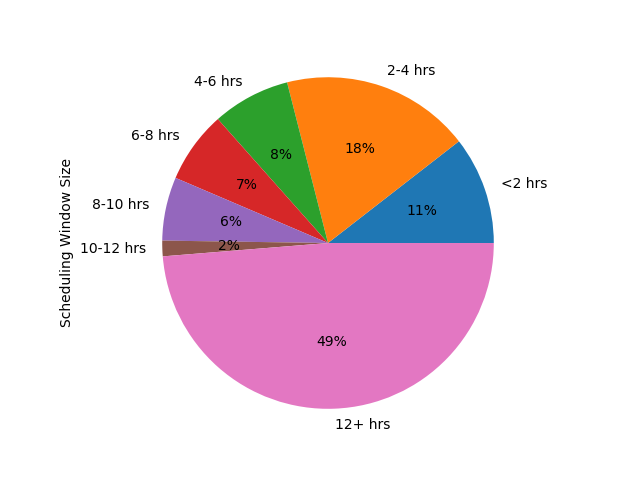

In [18]:
# number of SAs sent to the Scheduling Engine by Scheduling Window size

onsite_grouped_df["Scheduling Window Size"].count().plot(kind='pie',autopct='%1.0f%%')
plt.axis('equal')
plt.show()

# SAs that were scheduled

In [7]:
scheduled_df = onsite_df.loc[(file_df["SA: Schedule Exception Reason"] != "No SSRs were found.")]
num_scheduled = len(scheduled_df)
scheduled_grouped_df = scheduled_df.groupby(["Scheduling Window Size"])
scheduled_grouped_df["Scheduling Window Size"].count()

Scheduling Window Size
<2 hrs        21
2-4 hrs       57
4-6 hrs       21
6-8 hrs       29
8-10 hrs      29
10-12 hrs      7
12+ hrs      161
Name: Scheduling Window Size, dtype: int64

<IPython.core.display.Javascript object>


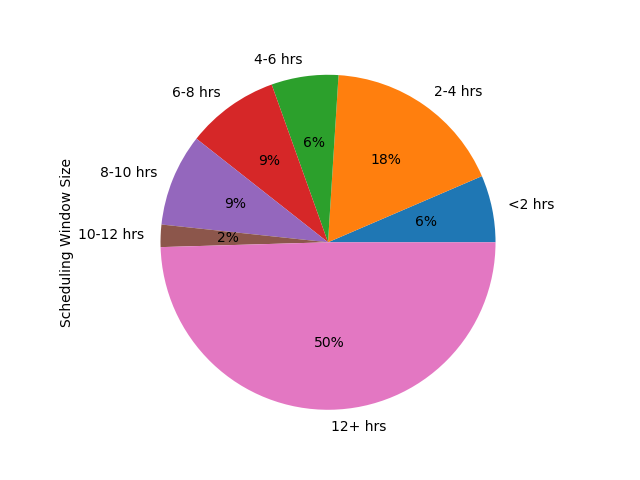

In [19]:
scheduled_grouped_df["Scheduling Window Size"].count().plot(kind='pie',autopct='%1.0f%%')
plt.axis('equal')
plt.show()

# No SSRs found

In [9]:
no_ssrs_found_df = onsite_df.loc[(file_df["SA: Schedule Exception Reason"] == "No SSRs were found.")]
num_no_ssrs_found = len(no_ssrs_found_df)
no_ssrs_grouped_df = no_ssrs_found_df.groupby(["Scheduling Window Size"])
no_ssrs_grouped_df["Scheduling Window Size"].count()

Scheduling Window Size
<2 hrs        69
2-4 hrs      101
4-6 hrs       44
6-8 hrs       31
8-10 hrs      24
10-12 hrs      6
12+ hrs      256
Name: Scheduling Window Size, dtype: int64

<IPython.core.display.Javascript object>


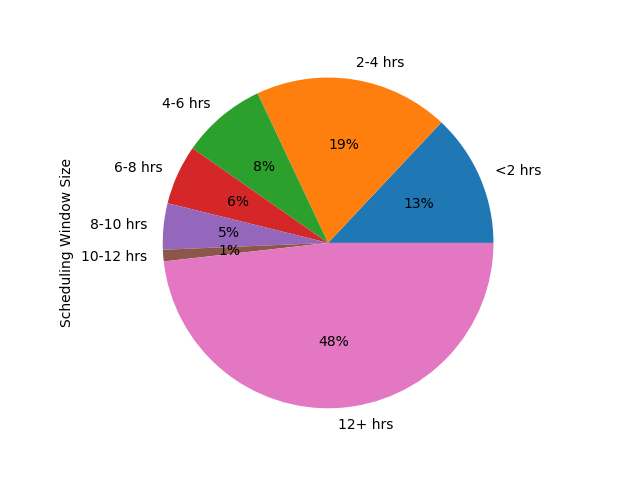

In [20]:
no_ssrs_grouped_df["Scheduling Window Size"].count().plot(kind='pie',autopct='%1.0f%%')
plt.axis('equal')
plt.show()

# AEDT SAs Scheduling Window Size

In [11]:
aedt_df = onsite_df.loc[(file_df["SA: Service Territory"] == "AU - ACT")|(file_df["SA: Service Territory"]=="AU - NSW")| \
                        (file_df["SA: Service Territory"] == "AU - Tasmania")|(file_df["SA: Service Territory"] == "AU - VIC")]
aedt_df_grouped = aedt_df.groupby(["Scheduling Window Size"])
aedt_df_grouped['Scheduling Window'].count()


Scheduling Window Size
<2 hrs        69
2-4 hrs      119
4-6 hrs       56
6-8 hrs       37
8-10 hrs      39
10-12 hrs     11
12+ hrs      295
Name: Scheduling Window, dtype: int64

<IPython.core.display.Javascript object>


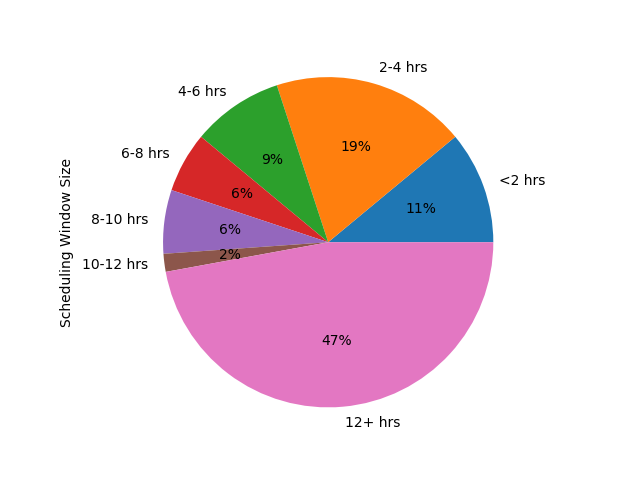

In [21]:
aedt_df_grouped["Scheduling Window Size"].count().plot(kind='pie',autopct='%1.0f%%')
plt.axis('equal')
plt.show()

# Schedule Exception Reasons

In [13]:
sched_excep_grouped = sched_excep_df.groupby(["SA: Schedule Exception Reason"])
sched_excep_grouped["SA: Schedule Exception Reason"].count()

SA: Schedule Exception Reason
Due Date is in the past.                                    34
Invalid "No Skill" Skill Requirement on the Work Order.    230
No Service Territory                                        42
Parts are not available by the Due Date.                   809
Name: SA: Schedule Exception Reason, dtype: int64

<IPython.core.display.Javascript object>


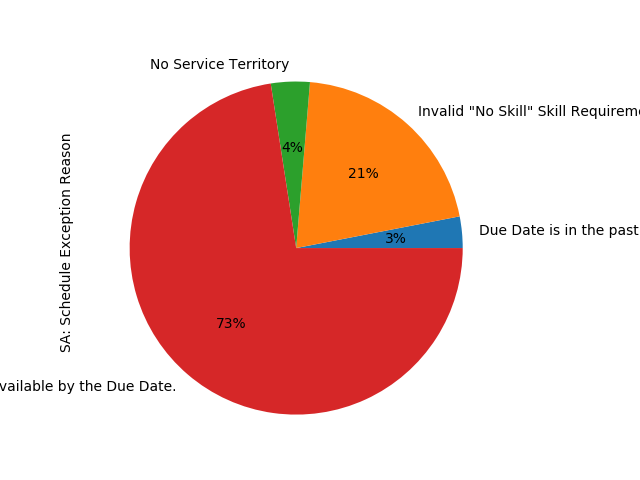

In [23]:
sched_excep_grouped["SA: Schedule Exception Reason"].count().plot(kind='pie',autopct='%1.0f%%')
plt.axis('equal')
plt.show()

# Autoscheduled SAs

In [50]:
auto_sched_df = file_df[file_df["SA: Schedule Mode"]=="Automatic"]
num_auto_sched = len(auto_sched_df)
